In [0]:
#Sources used: https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751
#              https://medium.com/@ODSC/how-to-leverage-pre-trained-layers-in-image-classification-31fb9b8cdd0
#              https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a
#Also based this a lot on the work of the other teammates too :)
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from pandas.io.json import json_normalize
import seaborn as sns

from PIL import Image
from io import BytesIO
import requests

import tensorflow
import keras
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras import models
# imports for loading and viewing image 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
import glob
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
cwd = os.getcwd()
print(cwd)
directory = '/content/gdrive/My Drive/data'
[x[0] for x in os.walk(directory)]

/content


['/content/gdrive/My Drive/data',
 '/content/gdrive/My Drive/data/validation_data',
 '/content/gdrive/My Drive/data/training_data',
 '/content/gdrive/My Drive/data/test_data']

In [0]:
IMG_DIM = (299, 299)

train_files = glob.glob('/content/gdrive/My Drive/data/training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)

validation_files = glob.glob('/content/gdrive/My Drive/data/validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (1894, 299, 299, 3) 	Validation dataset shape: (948, 299, 299, 3)


In [0]:
train_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in train_files]
validation_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in validation_files]

(299, 299, 3)


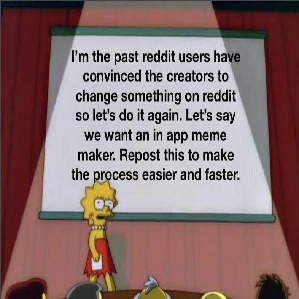

In [0]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [0]:
batch_size = 30
num_classes = 2
epochs = 5
input_shape = (299, 299, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505]) #0 is dank, 1 is not dank

['dank', 'dank', 'dank', 'dank', 'dank', 'dank', 'dank', 'dank', 'dank', 'dank'] [0 0 0 0 0 0 0 0 0 0]


In [0]:
from keras.models import Model
inception = inception_v3.InceptionV3(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = inception.layers[-1].output
output = keras.layers.Flatten()(output)
inception_model = Model(inception.input, output)

inception_model.trainable = False
for layer in inception_model.layers:
    layer.trainable = False
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in inception_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(10)    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == '':


,Layer Type,Layer Name,Layer Trainable
302,<keras.layers.core.Activation object at 0x7f0b19c77cc0>,activation_89,False
303,<keras.layers.core.Activation object at 0x7f0b19bfb128>,activation_92,False
304,<keras.layers.core.Activation object at 0x7f0b19bace80>,activation_93,False
305,<keras.layers.normalization.BatchNormalization object at 0x7f0b19b58b00>,batch_normalization_94,False
306,<keras.layers.core.Activation object at 0x7f0b19ce99e8>,activation_86,False
307,<keras.layers.merge.Concatenate object at 0x7f0b19c0de48>,mixed9_1,False
308,<keras.layers.merge.Concatenate object at 0x7f0b19b41f28>,concatenate_2,False
309,<keras.layers.core.Activation object at 0x7f0b19b70fd0>,activation_94,False
310,<keras.layers.merge.Concatenate object at 0x7f0b19b70f98>,mixed10,False
311,<keras.layers.core.Flatten object at 0x7f0b19b10f28>,flatten_1,False


(1, 8, 8, 2048)


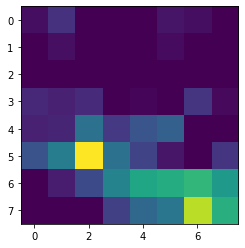

In [0]:
bottleneck_feature_example = inception.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [0]:
#unfreeze some layers
inception_model.trainable = True

retrain_layers = ['mixed10','mixed9_1']
set_trainable = False
for layer in inception_model.layers:
    if layer.name in retrain_layers:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in inception_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(10)   

,Layer Type,Layer Name,Layer Trainable
302,<keras.layers.core.Activation object at 0x7f0b19c77cc0>,activation_89,False
303,<keras.layers.core.Activation object at 0x7f0b19bfb128>,activation_92,False
304,<keras.layers.core.Activation object at 0x7f0b19bace80>,activation_93,False
305,<keras.layers.normalization.BatchNormalization object at 0x7f0b19b58b00>,batch_normalization_94,False
306,<keras.layers.core.Activation object at 0x7f0b19ce99e8>,activation_86,False
307,<keras.layers.merge.Concatenate object at 0x7f0b19c0de48>,mixed9_1,True
308,<keras.layers.merge.Concatenate object at 0x7f0b19b41f28>,concatenate_2,True
309,<keras.layers.core.Activation object at 0x7f0b19b70fd0>,activation_94,True
310,<keras.layers.merge.Concatenate object at 0x7f0b19b70f98>,mixed10,True
311,<keras.layers.core.Flatten object at 0x7f0b19b10f28>,flatten_1,True


In [0]:
# Image Augmentation generator to create variety of images
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)       

In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(inception_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])
              

In [0]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)     

Epoch 1/100
100/100 [==============================] - 63s 631ms/step - loss: 0.7795 - accuracy: 0.5040 - val_loss: 0.8439 - val_accuracy: 0.4980
Epoch 2/100
100/100 [==============================] - 52s 522ms/step - loss: 0.7475 - accuracy: 0.5349 - val_loss: 0.7094 - val_accuracy: 0.5263
Epoch 3/100
100/100 [==============================] - 54s 543ms/step - loss: 0.7249 - accuracy: 0.5417 - val_loss: 0.7400 - val_accuracy: 0.5111
Epoch 4/100
100/100 [==============================] - 54s 542ms/step - loss: 0.7162 - accuracy: 0.5553 - val_loss: 0.7618 - val_accuracy: 0.4929
Epoch 5/100
100/100 [==============================] - 54s 542ms/step - loss: 0.7049 - accuracy: 0.5646 - val_loss: 0.6001 - val_accuracy: 0.5283
Epoch 6/100
100/100 [==============================] - 55s 546ms/step - loss: 0.7106 - accuracy: 0.5454 - val_loss: 0.7193 - val_accuracy: 0.5040
Epoch 7/100
100/100 [==============================] - 54s 545ms/step - loss: 0.7055 - accuracy: 0.5656 - val_loss: 0.7524 -

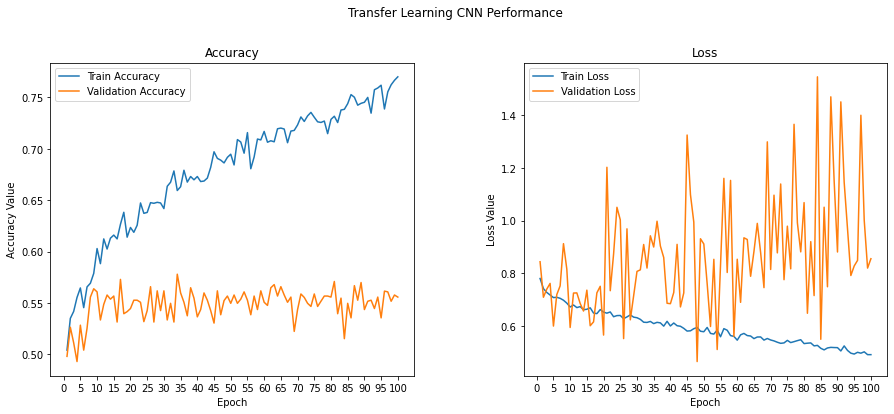

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
t = f.suptitle('Transfer Learning CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
model.save('/content/drive/My Drive/models/dank_not_dank_tlearn_finetune_img_aug_inception_100_cnn.h5')